In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Phemernr2-TF"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Phemernr2-TF_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(1705, 768)

In [3]:
data = pd.read_csv("../../data/processed/phemernr2-tf_dataset.csv", sep=",")
data.head()

,tweet_id,tweet_text,label,topic,tvt2
0,580318210609696769,BREAKING - A Germanwings Airbus A320 plane rep...,True,germanwings-crash-all-rnr-threads,training
1,552798891994009601,Reports that two of the dead in the #CharlieHe...,True,charliehebdo-all-rnr-threads,training
2,580352540316946432,'No survivors' in #Germanwings crash says Fren...,False,germanwings-crash-all-rnr-threads,training
3,524983403775799297,Tragedy mounts as soldier shot this AM dies of...,True,ottawashooting-all-rnr-threads,training
4,544511915158810624,Watch the moment gunfire and explosions were h...,True,sydneysiege-all-rnr-threads,training


In [4]:
labels_str = data['label'].unique().tolist()
labels_str

[True, False]

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label'])
#     labels.append([1 if j == lab else 0 for j in range(len(labels_str))])
    labels.append(lab)
labels[:10]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(1176, 768)
(371, 768)
(158, 768)
(1176,)
(371,)
(158,)


In [8]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(1547, 768)


In [9]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(1547,)


In [10]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [11]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 2-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 98.38709677419355
Saving after new best accuracy : 98.70967741935483
-- Epoch 50, Train_Accuracy : 97.41309620048504, Validation Accuracy : 97.74193548387096, Train Loss : 0.28758348152041435, Validation Loss : 0.04549075663089752
-- Epoch 100, Train_Accuracy : 98.94907033144705, Validation Accuracy : 98.70967741935483, Train Loss : 0.10513357911258936, Validation Loss : 0.033769890666007996
Saving after new best accuracy : 99.03225806451613
-- Epoch 150, Train_Accuracy : 99.51495553759095, Validation Accuracy : 98.06451612903226, Train Loss : 0.05938175739720464, Validation Loss : 0.0380031019449234
-- Epoch 200, Train_Accuracy : 99.75747776879547, Validation Accuracy : 98.70967741935483, Train Loss : 0.03203852102160454, Validation Loss : 0.03793668374419212
-- Epoch 250, Train_Accuracy : 99.91915925626516, Validation Accuracy : 98.70967741935483, Train 

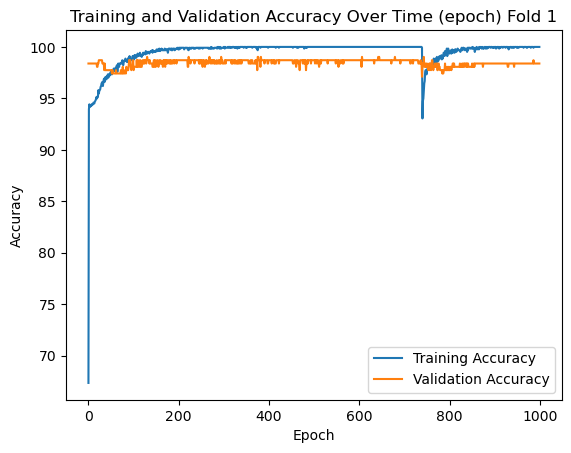

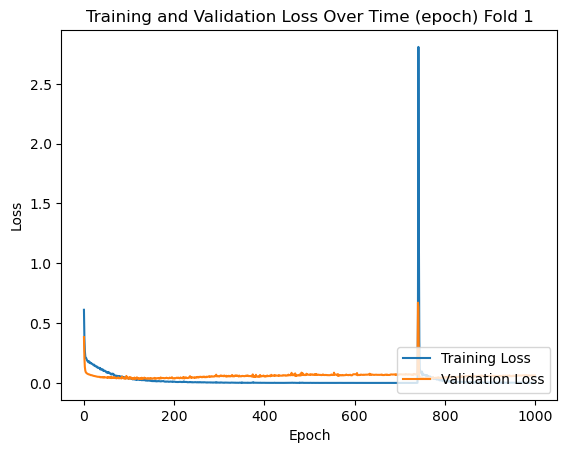

Exec Time : 17.31 seconds
loading model from ../../data/models/cross-validation/Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([1237])
Binary Class Evaluation

True Positive : 455
False Positive : 1
False Negative : 6
True Negative : 775

Class False Evaluation
- Precision : 99.781 %
- Recall : 98.698 %
- F1 : 0.99237

Class True Evaluation
- Precision : 99.232 %
- Recall : 99.871 %
- F1 : 0.9955

Combined Evaluation
- Accuracy : 99.434 %
- Precision : 99.506 %
- Recall : 99.285 %
- F1 : 0.99395
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Train, 99.434, 99.506, 99.285, 0.99395, 99.781, 98.698, 0.99237, 99.232, 99.871, 0.9955, 
Confusion Matrix Scikit-learn: 
[[775   1]
 [  6 455]]


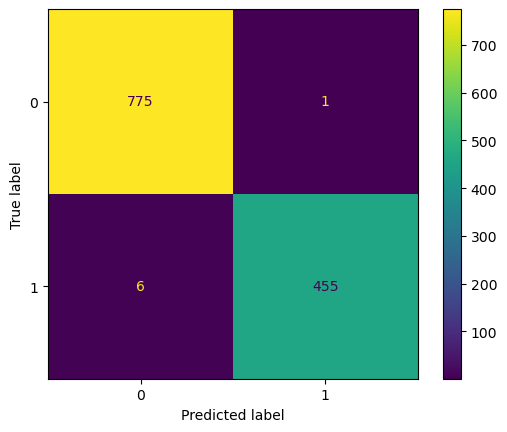


Validation Set
Predictions : torch.Size([310])
Binary Class Evaluation

True Positive : 114
False Positive : 1
False Negative : 2
True Negative : 193

Class False Evaluation
- Precision : 99.13 %
- Recall : 98.276 %
- F1 : 0.98701

Class True Evaluation
- Precision : 98.974 %
- Recall : 99.485 %
- F1 : 0.99229

Combined Evaluation
- Accuracy : 99.032 %
- Precision : 99.052 %
- Recall : 98.88 %
- F1 : 0.98966
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Validation, 99.032, 99.052, 98.88, 0.98966, 99.13, 98.276, 0.98701, 98.974, 99.485, 0.99229, 
Confusion Matrix Scikit-learn: 
[[193   1]
 [  2 114]]


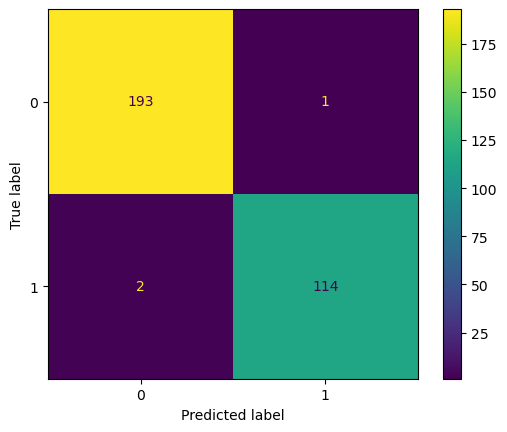


Test Set
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 50
False Positive : 6
False Negative : 11
True Negative : 91

Class False Evaluation
- Precision : 89.286 %
- Recall : 81.967 %
- F1 : 0.8547

Class True Evaluation
- Precision : 89.216 %
- Recall : 93.814 %
- F1 : 0.91457

Combined Evaluation
- Accuracy : 89.241 %
- Precision : 89.251 %
- Recall : 87.891 %
- F1 : 0.88566
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Test, 89.241, 89.251, 87.891, 0.88566, 89.286, 81.967, 0.8547, 89.216, 93.814, 0.91457, 
158
158
Confusion Matrix Scikit-learn: 
[[91  6]
 [11 50]]


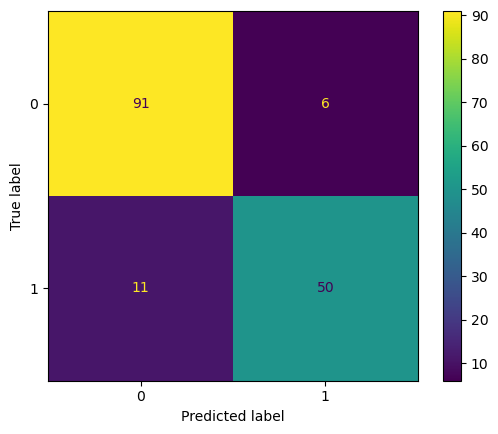

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 96.45161290322581
Saving after new best accuracy : 97.09677419354838
Saving after new best accuracy : 97.41935483870968
Saving after new best accuracy : 97.74193548387096
Saving after new best accuracy : 98.06451612903226
Saving after new best accuracy : 98.38709677419355
Saving after new best accuracy : 98.70967741935483
-- Epoch 50, Train_Accuracy : 97.25141471301536, Validation Accuracy : 98.70967741935483, Train Loss : 0.28064122051000595, Validation Loss : 0.0554964616894722
-- Epoch 100, Train_Accuracy : 98.94907033144705, Validation Accuracy : 98.38709677419355, Train Loss : 0.11587651632726192, Validation Loss : 0.048361264169216156
Saving after new best accuracy : 99.03225806451613
-- Epoch 150, Train_Accuracy : 99.4341147938561, Validation Accuracy : 98.70967741935483, Train Loss : 0.061959467362612486, Validation Loss : 0.06498638540506363
-- Epoch 200, Train_Accuracy : 99.83831851253032, Validation Accuracy : 98.70

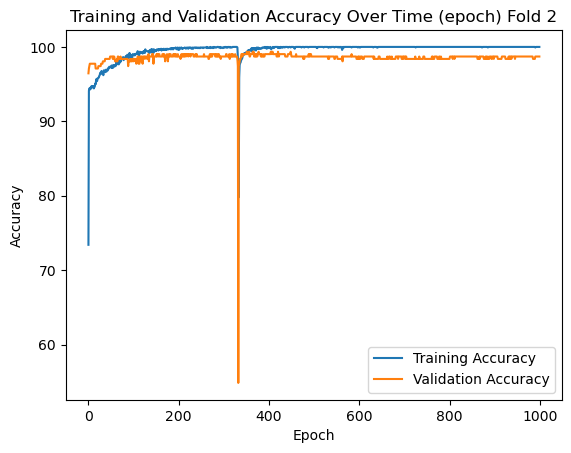

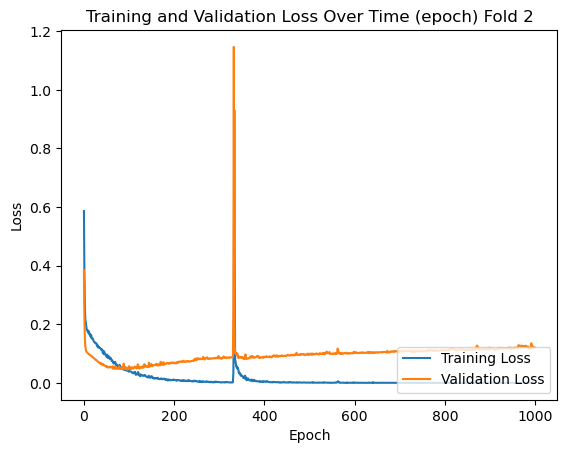

Exec Time : 14.89 seconds
loading model from ../../data/models/cross-validation/Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([1237])
Binary Class Evaluation

True Positive : 458
False Positive : 0
False Negative : 3
True Negative : 776

Class False Evaluation
- Precision : 100.0 %
- Recall : 99.349 %
- F1 : 0.99674

Class True Evaluation
- Precision : 99.615 %
- Recall : 100.0 %
- F1 : 0.99807

Combined Evaluation
- Accuracy : 99.757 %
- Precision : 99.807 %
- Recall : 99.675 %
- F1 : 0.99741
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Train, 99.757, 99.807, 99.675, 0.99741, 100.0, 99.349, 0.99674, 99.615, 100.0, 0.99807, 
Confusion Matrix Scikit-learn: 
[[776   0]
 [  3 458]]


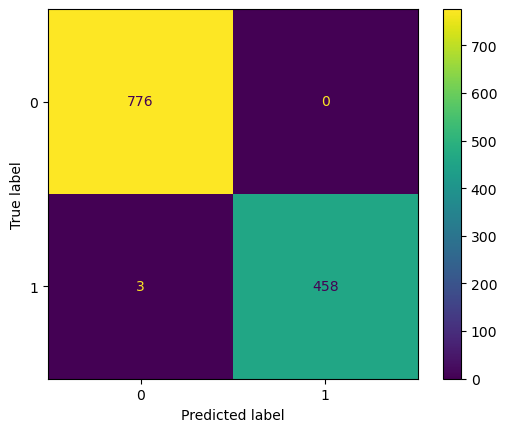


Validation Set
Predictions : torch.Size([310])
Binary Class Evaluation

True Positive : 115
False Positive : 1
False Negative : 1
True Negative : 193

Class False Evaluation
- Precision : 99.138 %
- Recall : 99.138 %
- F1 : 0.99138

Class True Evaluation
- Precision : 99.485 %
- Recall : 99.485 %
- F1 : 0.99485

Combined Evaluation
- Accuracy : 99.355 %
- Precision : 99.311 %
- Recall : 99.311 %
- F1 : 0.99311
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Validation, 99.355, 99.311, 99.311, 0.99311, 99.138, 99.138, 0.99138, 99.485, 99.485, 0.99485, 
Confusion Matrix Scikit-learn: 
[[193   1]
 [  1 115]]


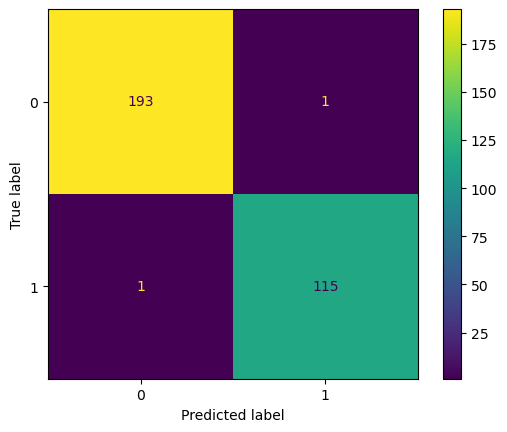


Test Set
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 52
False Positive : 9
False Negative : 9
True Negative : 88

Class False Evaluation
- Precision : 85.246 %
- Recall : 85.246 %
- F1 : 0.85246

Class True Evaluation
- Precision : 90.722 %
- Recall : 90.722 %
- F1 : 0.90722

Combined Evaluation
- Accuracy : 88.608 %
- Precision : 87.984 %
- Recall : 87.984 %
- F1 : 0.87984
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Test, 88.608, 87.984, 87.984, 0.87984, 85.246, 85.246, 0.85246, 90.722, 90.722, 0.90722, 
158
158
Confusion Matrix Scikit-learn: 
[[88  9]
 [ 9 52]]


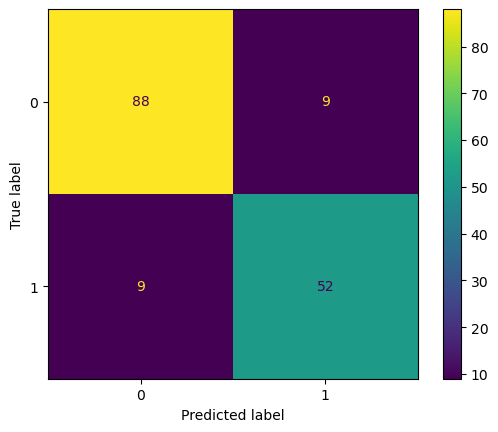

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 97.0873786407767
Saving after new best accuracy : 97.41100323624596
Saving after new best accuracy : 97.73462783171522
Saving after new best accuracy : 98.05825242718447
Saving after new best accuracy : 98.38187702265373
Saving after new best accuracy : 98.70550161812298
Saving after new best accuracy : 99.02912621359224
-- Epoch 50, Train_Accuracy : 97.25363489499192, Validation Accuracy : 98.70550161812298, Train Loss : 0.27420851215720177, Validation Loss : 0.04812484234571457
-- Epoch 100, Train_Accuracy : 98.78836833602585, Validation Accuracy : 98.38187702265373, Train Loss : 0.1330151241272688, Validation Loss : 0.04368729144334793
-- Epoch 150, Train_Accuracy : 99.43457189014539, Validation Accuracy : 98.38187702265373, Train Loss : 0.0533567126840353, Validation Loss : 0.04777845740318298
-- Epoch 200, Train_Accuracy : 99.75767366720517, Validation Accuracy : 98.05825242718447, Train Loss : 0.028432180639356375, Valid

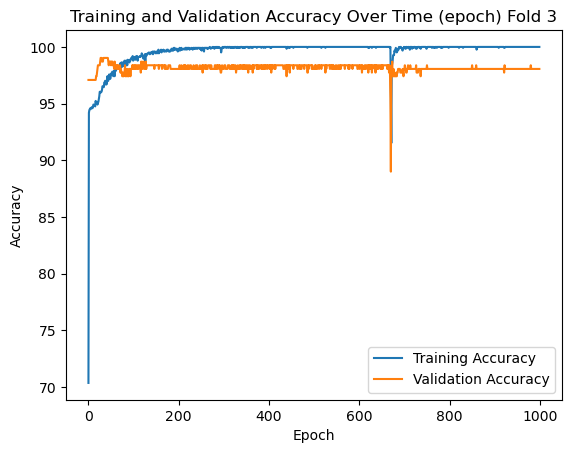

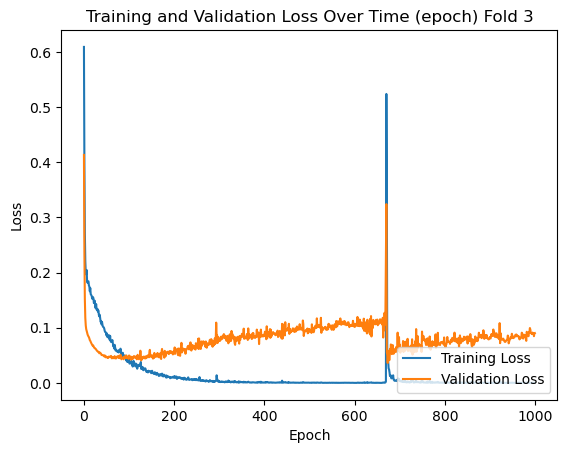

Exec Time : 15.07 seconds
loading model from ../../data/models/cross-validation/Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([1238])
Binary Class Evaluation

True Positive : 434
False Positive : 16
False Negative : 28
True Negative : 760

Class False Evaluation
- Precision : 96.444 %
- Recall : 93.939 %
- F1 : 0.95175

Class True Evaluation
- Precision : 96.447 %
- Recall : 97.938 %
- F1 : 0.97187

Combined Evaluation
- Accuracy : 96.446 %
- Precision : 96.446 %
- Recall : 95.939 %
- F1 : 0.96192
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Train, 96.446, 96.446, 95.939, 0.96192, 96.444, 93.939, 0.95175, 96.447, 97.938, 0.97187, 
Confusion Matrix Scikit-learn: 
[[760  16]
 [ 28 434]]


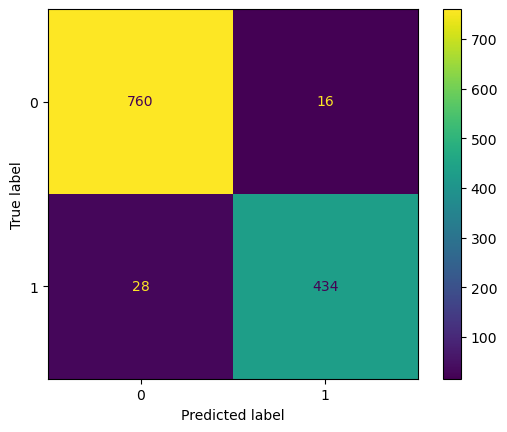


Validation Set
Predictions : torch.Size([309])
Binary Class Evaluation

True Positive : 112
False Positive : 0
False Negative : 3
True Negative : 194

Class False Evaluation
- Precision : 100.0 %
- Recall : 97.391 %
- F1 : 0.98678

Class True Evaluation
- Precision : 98.477 %
- Recall : 100.0 %
- F1 : 0.99233

Combined Evaluation
- Accuracy : 99.029 %
- Precision : 99.239 %
- Recall : 98.696 %
- F1 : 0.98967
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Validation, 99.029, 99.239, 98.696, 0.98967, 100.0, 97.391, 0.98678, 98.477, 100.0, 0.99233, 
Confusion Matrix Scikit-learn: 
[[194   0]
 [  3 112]]


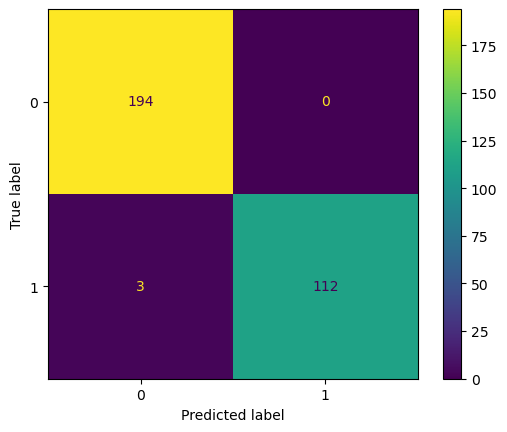


Test Set
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 51
False Positive : 10
False Negative : 10
True Negative : 87

Class False Evaluation
- Precision : 83.607 %
- Recall : 83.607 %
- F1 : 0.83607

Class True Evaluation
- Precision : 89.691 %
- Recall : 89.691 %
- F1 : 0.89691

Combined Evaluation
- Accuracy : 87.342 %
- Precision : 86.649 %
- Recall : 86.649 %
- F1 : 0.86649
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Test, 87.342, 86.649, 86.649, 0.86649, 83.607, 83.607, 0.83607, 89.691, 89.691, 0.89691, 
158
158
Confusion Matrix Scikit-learn: 
[[87 10]
 [10 51]]


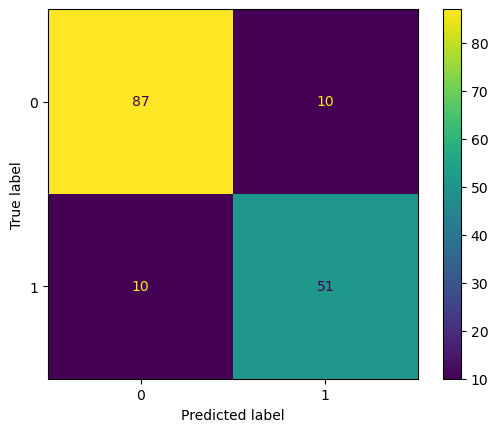

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 94.8220064724919
Saving after new best accuracy : 95.14563106796116
Saving after new best accuracy : 95.79288025889967
Saving after new best accuracy : 96.11650485436893
Saving after new best accuracy : 96.44012944983818
Saving after new best accuracy : 96.76375404530744
Saving after new best accuracy : 97.0873786407767
Saving after new best accuracy : 97.73462783171522
Saving after new best accuracy : 98.05825242718447
-- Epoch 50, Train_Accuracy : 97.33441033925686, Validation Accuracy : 97.73462783171522, Train Loss : 0.26869938895106316, Validation Loss : 0.08425484597682953
-- Epoch 100, Train_Accuracy : 99.35379644588045, Validation Accuracy : 97.41100323624596, Train Loss : 0.0878865197300911, Validation Loss : 0.10103078931570053
-- Epoch 150, Train_Accuracy : 99.75767366720517, Validation Accuracy : 97.41100323624596, Train Loss : 0.03780640847980976, Validation Loss : 0.12953053414821625
-- Epoch 200, Train_Accuracy 

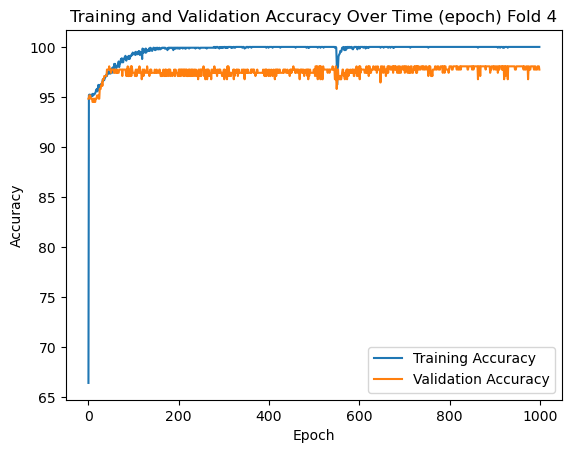

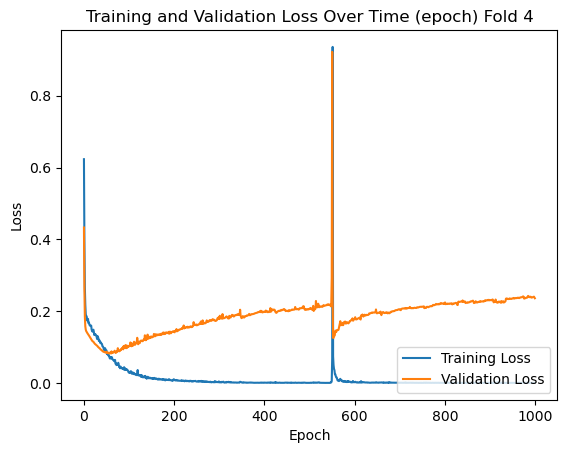

Exec Time : 14.35 seconds
loading model from ../../data/models/cross-validation/Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([1238])
Binary Class Evaluation

True Positive : 442
False Positive : 11
False Negative : 20
True Negative : 765

Class False Evaluation
- Precision : 97.572 %
- Recall : 95.671 %
- F1 : 0.96612

Class True Evaluation
- Precision : 97.452 %
- Recall : 98.582 %
- F1 : 0.98014

Combined Evaluation
- Accuracy : 97.496 %
- Precision : 97.512 %
- Recall : 97.127 %
- F1 : 0.97319
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Train, 97.496, 97.512, 97.127, 0.97319, 97.572, 95.671, 0.96612, 97.452, 98.582, 0.98014, 
Confusion Matrix Scikit-learn: 
[[765  11]
 [ 20 442]]


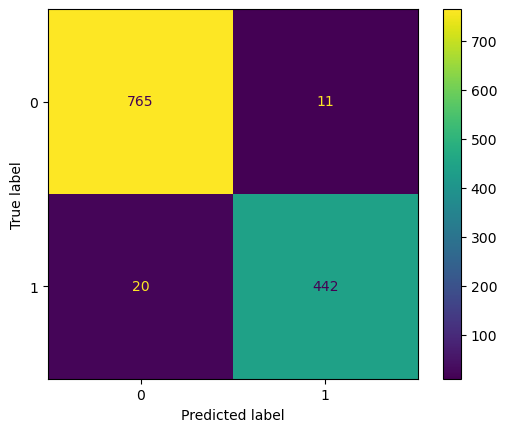


Validation Set
Predictions : torch.Size([309])
Binary Class Evaluation

True Positive : 113
False Positive : 4
False Negative : 2
True Negative : 190

Class False Evaluation
- Precision : 96.581 %
- Recall : 98.261 %
- F1 : 0.97414

Class True Evaluation
- Precision : 98.958 %
- Recall : 97.938 %
- F1 : 0.98446

Combined Evaluation
- Accuracy : 98.058 %
- Precision : 97.77 %
- Recall : 98.1 %
- F1 : 0.97935
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Validation, 98.058, 97.77, 98.1, 0.97935, 96.581, 98.261, 0.97414, 98.958, 97.938, 0.98446, 
Confusion Matrix Scikit-learn: 
[[190   4]
 [  2 113]]


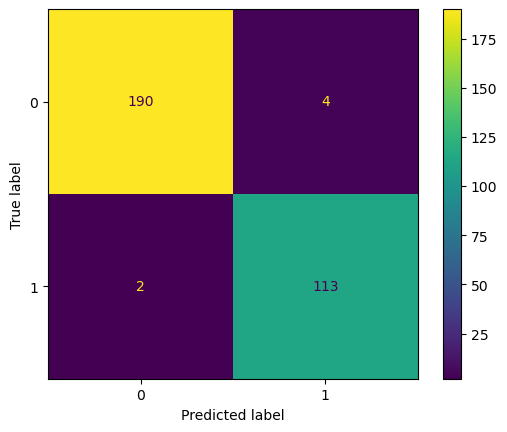


Test Set
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 53
False Positive : 8
False Negative : 8
True Negative : 89

Class False Evaluation
- Precision : 86.885 %
- Recall : 86.885 %
- F1 : 0.86885

Class True Evaluation
- Precision : 91.753 %
- Recall : 91.753 %
- F1 : 0.91753

Combined Evaluation
- Accuracy : 89.873 %
- Precision : 89.319 %
- Recall : 89.319 %
- F1 : 0.89319
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Test, 89.873, 89.319, 89.319, 0.89319, 86.885, 86.885, 0.86885, 91.753, 91.753, 0.91753, 
158
158
Confusion Matrix Scikit-learn: 
[[89  8]
 [ 8 53]]


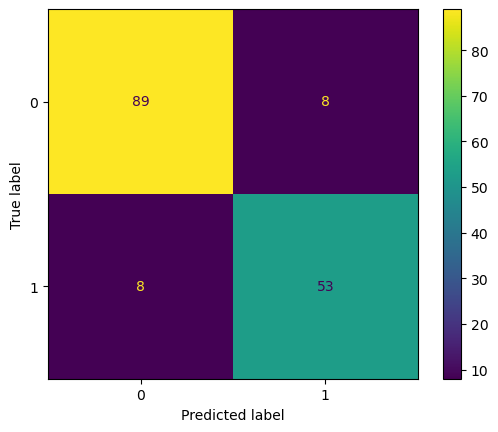

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 88.02588996763754
Saving after new best accuracy : 88.3495145631068
Saving after new best accuracy : 88.67313915857605
Saving after new best accuracy : 88.9967637540453
Saving after new best accuracy : 89.32038834951456
Saving after new best accuracy : 89.96763754045307
Saving after new best accuracy : 90.29126213592232
Saving after new best accuracy : 90.61488673139158
Saving after new best accuracy : 90.93851132686085
-- Epoch 50, Train_Accuracy : 98.78836833602585, Validation Accuracy : 90.93851132686085, Train Loss : 0.14374594390392303, Validation Loss : 0.3254188895225525
Saving after new best accuracy : 91.2621359223301
Saving after new best accuracy : 91.58576051779936
-- Epoch 100, Train_Accuracy : 99.67689822294022, Validation Accuracy : 90.93851132686085, Train Loss : 0.05009044241160154, Validation Loss : 0.3913978934288025
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 90.61488673139158, Train Loss : 

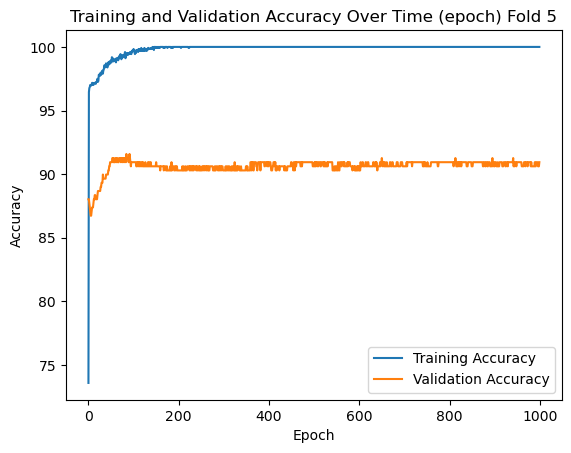

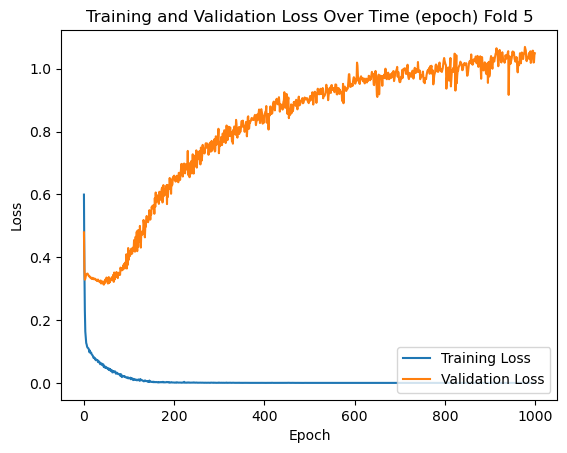

Exec Time : 14.44 seconds
loading model from ../../data/models/cross-validation/Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([1238])
Binary Class Evaluation

True Positive : 456
False Positive : 0
False Negative : 6
True Negative : 776

Class False Evaluation
- Precision : 100.0 %
- Recall : 98.701 %
- F1 : 0.99346

Class True Evaluation
- Precision : 99.233 %
- Recall : 100.0 %
- F1 : 0.99615

Combined Evaluation
- Accuracy : 99.515 %
- Precision : 99.616 %
- Recall : 99.351 %
- F1 : 0.99483
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Train, 99.515, 99.616, 99.351, 0.99483, 100.0, 98.701, 0.99346, 99.233, 100.0, 0.99615, 
Confusion Matrix Scikit-learn: 
[[776   0]
 [  6 456]]


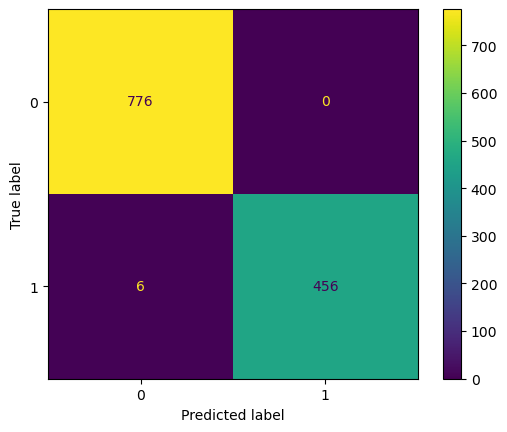


Validation Set
Predictions : torch.Size([309])
Binary Class Evaluation

True Positive : 98
False Positive : 9
False Negative : 17
True Negative : 185

Class False Evaluation
- Precision : 91.589 %
- Recall : 85.217 %
- F1 : 0.88288

Class True Evaluation
- Precision : 91.584 %
- Recall : 95.361 %
- F1 : 0.93434

Combined Evaluation
- Accuracy : 91.586 %
- Precision : 91.586 %
- Recall : 90.289 %
- F1 : 0.90933
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Validation, 91.586, 91.586, 90.289, 0.90933, 91.589, 85.217, 0.88288, 91.584, 95.361, 0.93434, 
Confusion Matrix Scikit-learn: 
[[185   9]
 [ 17  98]]


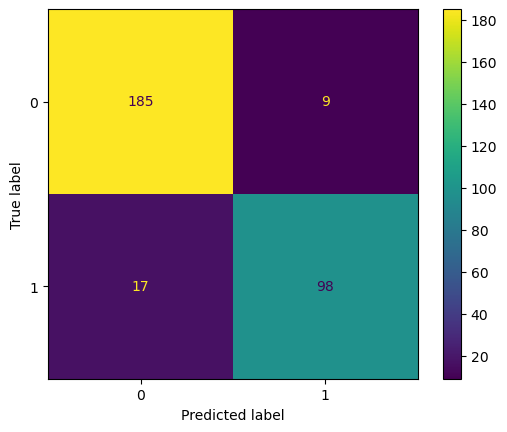


Test Set
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 54
False Positive : 9
False Negative : 7
True Negative : 88

Class False Evaluation
- Precision : 85.714 %
- Recall : 88.525 %
- F1 : 0.87097

Class True Evaluation
- Precision : 92.632 %
- Recall : 90.722 %
- F1 : 0.91667

Combined Evaluation
- Accuracy : 89.873 %
- Precision : 89.173 %
- Recall : 89.623 %
- F1 : 0.89397
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_2LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Test, 89.873, 89.173, 89.623, 0.89397, 85.714, 88.525, 0.87097, 92.632, 90.722, 0.91667, 
158
158
Confusion Matrix Scikit-learn: 
[[88  9]
 [ 7 54]]


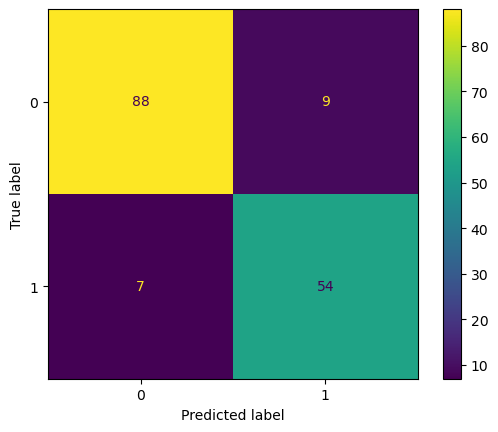

In [12]:
print("Multiclass Classification using 2-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_2LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()